In [48]:
import pandas as pd

In [49]:
data = pd.read_excel("../../data/fake_job_postings.xlsx")

In [51]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI â€“ Environmental Systems Re...,"EDUCATION:Â Bachelorâ€™s or Masterâ€™s in GIS,...",Our culture is anything but corporateâ€”we hav...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [50]:
data.shape

(17880, 18)

In [ ]:
fraud = data[data['fraudulent'] == 1]

In [ ]:
fraud.shape

In [ ]:
real = data[data['fraudulent'] == 0]

In [ ]:
real.shape

In [ ]:
real.describe()

In [ ]:
fake = fraud.iloc[0:30]

In [ ]:
fake.shape

In [ ]:
real_data = real.iloc[0:30]

In [ ]:
real_data.shape

In [ ]:
small_balanced_data = pd.concat([fake, real_data])

In [ ]:
small_balanced_data

In [ ]:
import random

In [ ]:
small_balanced_data_random = small_balanced_data.sample(frac=1).reset_index(drop=True)

In [ ]:
small_balanced_data_random

In [ ]:
small_balanced_data_random.to_json(orient="records")

In [ ]:
data.dtypes

In [ ]:
data['location'] = data['location'].astype(str)

In [ ]:
def split(location):
    l = location.split(',')
    return l[0]

data['country'] = data.location.apply(split)

In [ ]:
country = dict(data.country.value_counts()[:11])

In [ ]:
country

In [ ]:
experience = dict(data.required_experience.value_counts())

In [ ]:
experience

In [ ]:
######### More EDAs ############

In [ ]:
import pandas as pd
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import os 
import re
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import spacy
import scattertext as st
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

In [ ]:
sw = stopwords.words("english")

In [ ]:
df = pd.read_excel("../../data/fake_job_postings.xlsx")

In [ ]:
# replace null to "missing"
for c in df.columns:
    df[c] = np.where(df[c].isnull(), 'missing', df[c])

In [ ]:
df

In [ ]:
# separate location attributes
df['country'] = df.location.str.split(',').str[0]
df['state'] = df.location.str.split(', ').str[1]
df['city'] = df.location.str.split(', ').str[2]

In [ ]:
# drop non-english postings
df['language'] = df['description'].apply(lambda x: detect(x))
df = df[df.language == 'en']

In [ ]:
# spot cleanup for nyc abbreviations
df.city = np.where(df.city == 'nyc', 'new york city', df.city)
df.city = np.where(df.city == 'ny', 'new york city', df.city)
df.city = np.where(df.city == 'new york', 'new york city', df.city)

In [ ]:
# text cleaning 
text_columns = ['country', 'state', 'city', 'title', 'department', 'company_profile', 'description', 'requirements',
               'benefits', 'required_experience', 'employment_type', 'required_education', 'industry', 'function']
for c in text_columns:
    df[c] = df[c].apply(lambda x: re.sub(r'â€™', '', str(x))) # remove specific character used for apostrophe
                                                              # replace with '' before ascii removal so contractions together
    df[c] = df[c].str.replace('([A-Z])((?=[a-z]))', r' \1') # if lower case followed by upper case, separate by space
                                                            # works for a.A as well 
    df[c] = df[c].str.lower() # downcase 
    df[c] = np.where(df[c] == '', 'missing', df[c]) # empty strings mark as missing
    df[c] = df[c].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in str(x)])) # remove non-ascii
    df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub(r'[^\w\s]','', x)) # remove punctuation. Replace with '' so don't separate contractions
    df[c] = df[c].apply(lambda x: re.sub(' +', ' ', x)) # remove double and triple spaces
    df[c] = df[c].apply(lambda x: str(x).strip()) # remove white space trailing/leading

In [ ]:
# redefine education bins
df['education_bin'] = np.where(df.required_education.isin(['some high school coursework']),
                               'less than high school', df.required_education)
df.education_bin = np.where(df.required_education.isin(['high school or equivalent']), 'high school', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['vocational hs diploma', 'vocational degree',
                                                       'vocational']), 'vocational', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['some college coursework completed']), 'some college', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['unspecified']), "missing", df.education_bin)

In [ ]:
# drop salary range variable 
del df['salary_range']

In [ ]:
df

In [ ]:
df.fraudulent = pd.to_numeric(df.fraudulent)

In [ ]:
df

In [ ]:
import openpyxl

In [ ]:
df.to_excel("./data/clean_fake_job_postings.xlsx")

In [ ]:
def bar_plt(col, titlecol, boolean = False):
    
    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = df.groupby(col).fraudulent.sum().to_frame()
    totcnt = df.groupby(col).job_id.count().to_frame()
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True)
    frac['frac'] = frac.fraudulent / frac.job_id 
    
    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]
    
    # sort and take top 10 
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)
    
    dictionaryFormat = frac[['index_col', 'frac']].to_dict('records')
    print (dictionaryFormat)
    print (frac[['index_col', 'frac']])
    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'])
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])
        
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')
        
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

In [ ]:
bar_plt('industry', 'Industries')

Imports

In [3]:
import pandas as pd
import numpy as np 
import pickle
import matplotlib.pyplot as plt
import os 
import re
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import seaborn as sns
import spacy
import scattertext as st
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
import fastparquet

In [4]:
sw = stopwords.words("english")

In [7]:
df = pd.read_excel('../../data/fake_job_postings.xlsx')

Cleanind the Data

In [8]:
# replace null to "missing"
for c in df.columns:
    df[c] = np.where(df[c].isnull(), 'missing', df[c])

In [9]:
# separate location attributes
df['country'] = df.location.str.split(',').str[0]
df['state'] = df.location.str.split(', ').str[1]
df['city'] = df.location.str.split(', ').str[2]

In [10]:
# drop non-english postings
df['language'] = df['description'].apply(lambda x: detect(x))
df = df[df.language == 'en']

In [11]:
# text cleaning 
text_columns = ['country', 'state', 'city', 'title', 'department', 'company_profile', 'description', 'requirements',
               'benefits', 'required_experience', 'employment_type', 'required_education', 'industry', 'function']
for c in text_columns:
    df[c] = df[c].apply(lambda x: re.sub(r'â€™', '', str(x))) # remove specific character used for apostrophe
                                                              # replace with '' before ascii removal so contractions together
    df[c] = df[c].str.replace('([A-Z])((?=[a-z]))', r' \1') # if lower case followed by upper case, separate by space
                                                            # works for a.A as well 
    df[c] = df[c].str.lower() # downcase 
    df[c] = np.where(df[c] == '', 'missing', df[c]) # empty strings mark as missing
    df[c] = df[c].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in str(x)])) # remove non-ascii
    df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs
    df[c] = df[c].apply(lambda x: re.sub(r'[^\w\s]','', x)) # remove punctuation. Replace with '' so don't separate contractions
    df[c] = df[c].apply(lambda x: re.sub(' +', ' ', x)) # remove double and triple spaces
    df[c] = df[c].apply(lambda x: str(x).strip()) # remove white space trailing/leading

<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<>:13: DeprecationWarning: invalid escape sequence \s
<ipython-input-11-1762eb734427>:12: DeprecationWarning: invalid escape sequence \s
  df[c] = df[c].apply(lambda x: re.sub('http[^\s]+ ', ' ', str(x))) # remove URLs
<ipython-input-11-1762eb734427>:13: DeprecationWarning: invalid escape sequence \s
  df[c] = df[c].apply(lambda x: re.sub('url[^\s]+ ', ' ', str(x))) # remove URLs


In [12]:
# spot cleanup for nyc abbreviations
df.city = np.where(df.city == 'nyc', 'new york city', df.city)
df.city = np.where(df.city == 'ny', 'new york city', df.city)
df.city = np.where(df.city == 'new york', 'new york city', df.city)

# spot cleanup experience
df.required_experience = np.where(df.required_experience == 'not applicable', 'missing', df.required_experience)

In [13]:
# redefine education bins
df['education_bin'] = np.where(df.required_education.isin(['some high school coursework']),
                               'less than high school', df.required_education)
df.education_bin = np.where(df.required_education.isin(['high school or equivalent']), 'high school', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['vocational hs diploma', 'vocational degree',
                                                       'vocational']), 'vocational', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['some college coursework completed']), 'some college', df.education_bin)
df.education_bin = np.where(df.required_education.isin(['unspecified']), "missing", df.education_bin)

In [14]:
# drop salary range variable 
del df['salary_range']

In [15]:
df.fraudulent = pd.to_numeric(df.fraudulent)

In [16]:
# Function to plot distribution of variables
# Inputs:
    # col: feature we want to graph distribution of
    # title: title of plot
    # boolean: True if variable is boolean -> different formatting
    # tail: True if plot head and tail of distribution if many values. False if plot all values
def hist_plt(col, title, boolean = False, tail = False):
    
    # 1 vs 2 plots in the figure
    if tail:
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
        num = 10
    else:
        f, ax1 = plt.subplots()
        num = 1000
        
    # get value counts for distribution
    head = df[col].value_counts().head(num)
    
    # plot
    if boolean == False:
        ax1.bar(head.index, head)
        ax1.set_xticklabels(labels = head.index, rotation=90)
    # if boolean, need to sort in consistent No, Yes order rather than by value counts 
    else:
        bplt = df[col].value_counts()
        bplt = bplt.sort_index() # need to be in No, Yes order
        ax1.bar(bplt.index, bplt)
        ax1.set_xticks([0, 1])
        ax1.set_xticklabels(labels = ['No', 'Yes'])
    
    # second plot if need to plot distribution tail
    if tail:
        tail = df[col].value_counts().tail(10)
        ax2.bar(tail.index, tail)
        ax2.set_xticklabels(labels = tail.index, rotation=90)
        
    # title
    f.suptitle(title, fontsize=16)
    
    return ax1.get_figure()

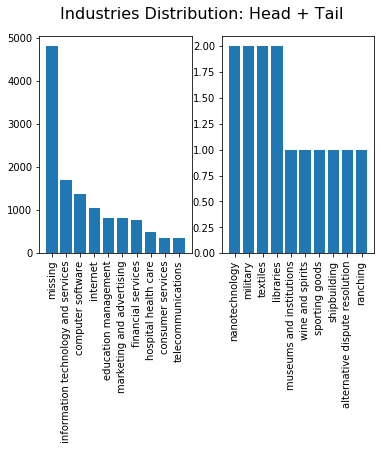

In [17]:
ind_dist = hist_plt('industry', 'Industries Distribution: Head + Tail', tail = True)

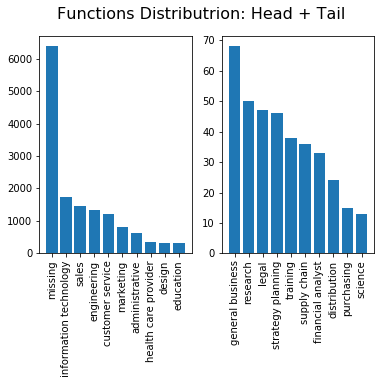

In [18]:
fun_dist = hist_plt('function', 'Functions Distributrion: Head + Tail', tail = True)

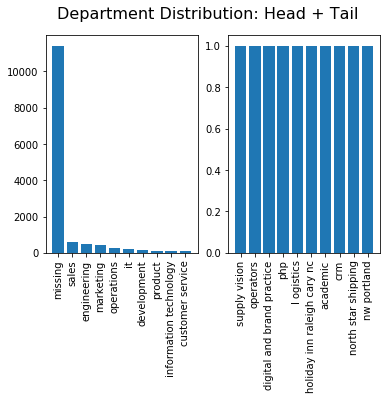

In [19]:
dep_dist = hist_plt('department', 'Department Distribution: Head + Tail', tail = True)

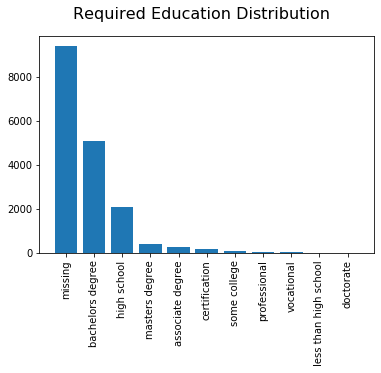

In [20]:
edu_dist = hist_plt('education_bin', 'Required Education Distribution')

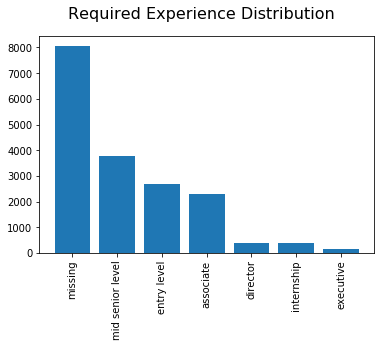

In [21]:
exp_dist = hist_plt('required_experience', 'Required Experience Distribution')

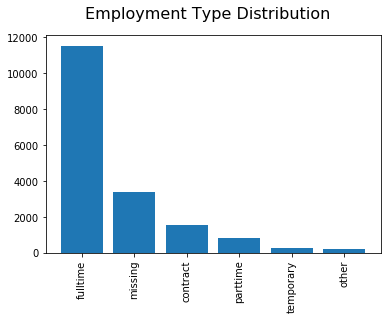

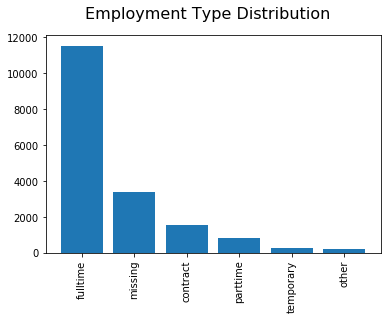

In [22]:
hist_plt('employment_type', 'Employment Type Distribution')

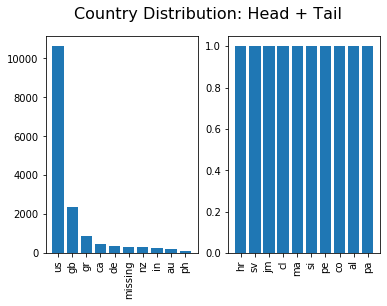

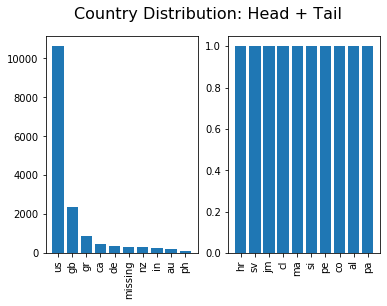

In [23]:
hist_plt('country', 'Country Distribution: Head + Tail', tail = True)

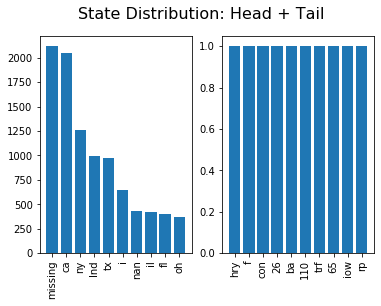

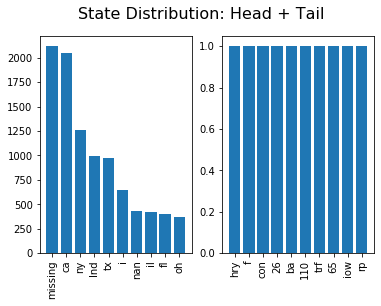

In [24]:
hist_plt('state', 'State Distribution: Head + Tail', tail = True)

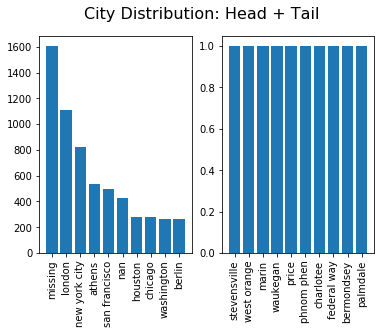

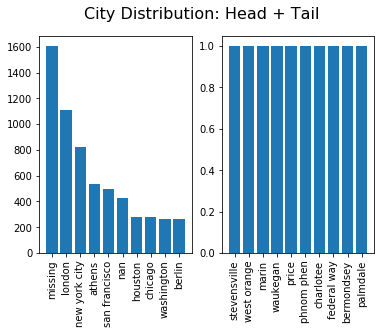

In [25]:
hist_plt('city', 'City Distribution: Head + Tail', tail = True)

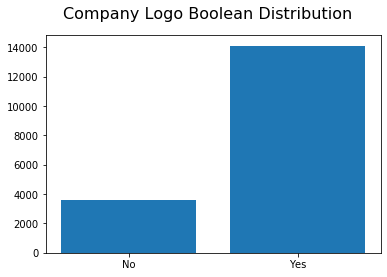

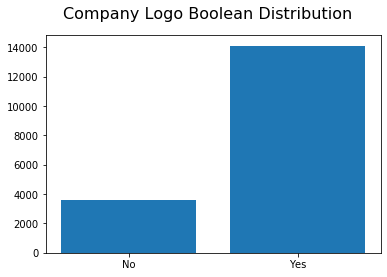

In [26]:
hist_plt('has_company_logo', 'Company Logo Boolean Distribution', boolean = True)

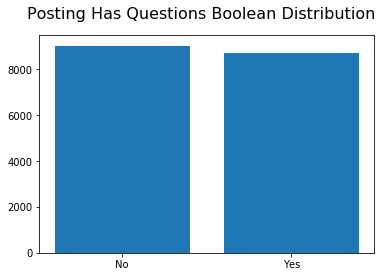

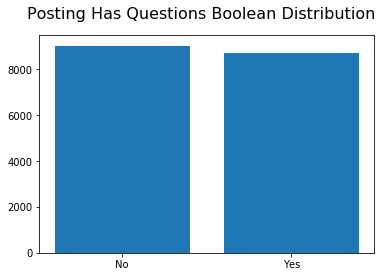

In [27]:
hist_plt('has_questions', 'Posting Has Questions Boolean Distribution', boolean = True)

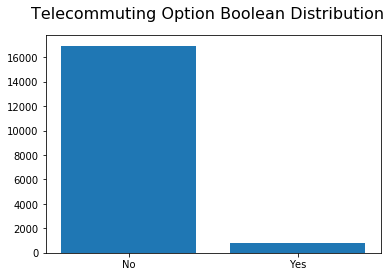

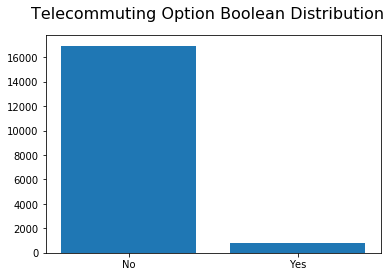

In [28]:
hist_plt('telecommuting', 'Telecommuting Option Boolean Distribution', boolean = True)

Bar Plots of Metadata Frequency in Fraudulent Posts

In [29]:
# inputs:
    # col: feature we want to plot
    # titlecol: title for graph
    # boolean: True if boolean value -> different formatting
def bar_plt(col, titlecol, boolean = False):
    
    # count number of fraudulent postings and total postings -> calculate fraction of postings that are fraud
    fraudcnt = df.groupby(col).fraudulent.sum().to_frame() # number fraud
    totcnt = df.groupby(col).job_id.count().to_frame() # number in general
    frac = pd.merge(fraudcnt, totcnt, left_index = True, right_index = True) # merge
    frac['frac'] = frac.fraudulent / frac.job_id # fraction fraud
    
    # exclude if fewer than 10 total postings (else fraction may be close to 100%)
    frac = frac[frac.job_id > 10]
    
    # sort 
    frac['index_col'] = frac.index
    frac = frac.reset_index(drop = True)
    # take top 10 if not boolean
    if boolean == False:
        frac = frac.sort_values('frac').tail(10)

    # plot
    cnt = len(frac)
    sns.barplot(x='index_col', y="frac", data=frac, order=frac['index_col'])
    
    # xtick format
    if boolean == False:
        plt.xticks(rotation=90)
    else:
        plt.xticks([0, 1], ['No', 'Yes'])
        
    # title
    # if top 10 was not the full amount, say top 10 in title. Else, all values
    if cnt == 10:
        plt.title('Top 10 ' + titlecol + ' by Percent Fraudulent Postings')
    else:
        plt.title(titlecol + ' by Percent Fraudulent Postings')
        
    # label
    plt.ylabel('Fraction of Fraudulent Postings')
    plt.xlabel('')

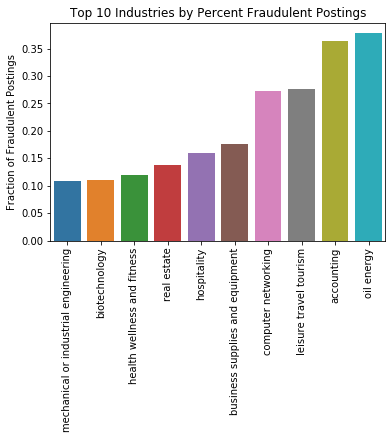

In [30]:
bar_plt('industry', 'Industries')

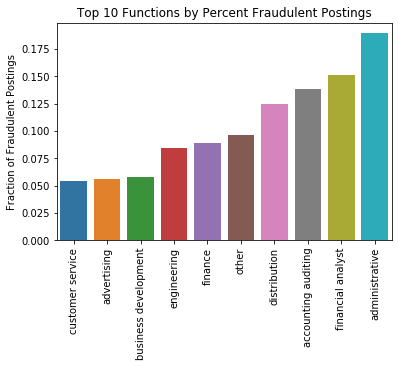

In [31]:
bar_plt('function', 'Functions')

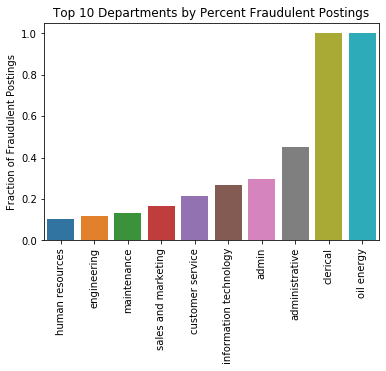

In [32]:
bar_plt('department', 'Departments')
# clerical and oil energy appear to be the same handful of job postings posted many times with different locations or titles

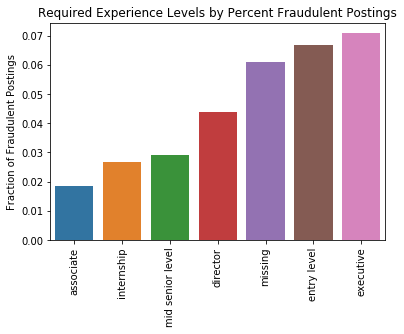

In [33]:
bar_plt('required_experience', 'Required Experience Levels')

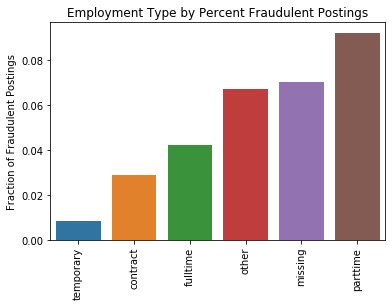

In [34]:
bar_plt('employment_type', 'Employment Type')

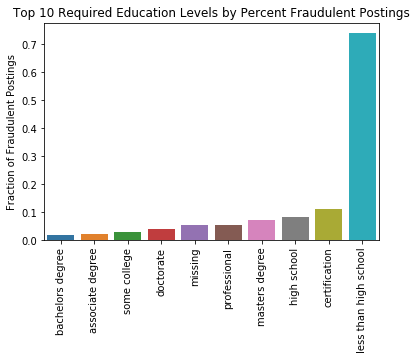

In [35]:
bar_plt('education_bin', 'Required Education Levels')

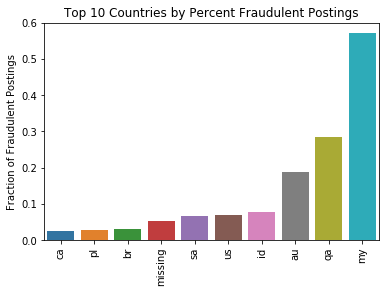

In [36]:
bar_plt('country', 'Countries')

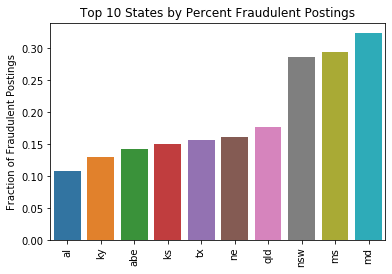

In [37]:
bar_plt('state', 'States')

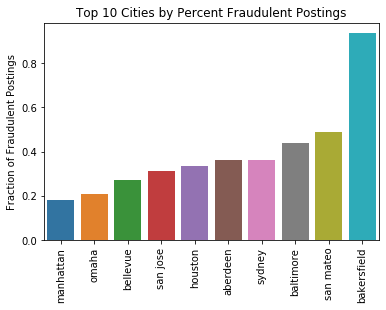

In [38]:
bar_plt('city', 'Cities')

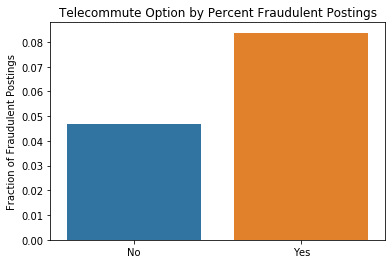

In [39]:
bar_plt('telecommuting', 'Telecommute Option', boolean = True)

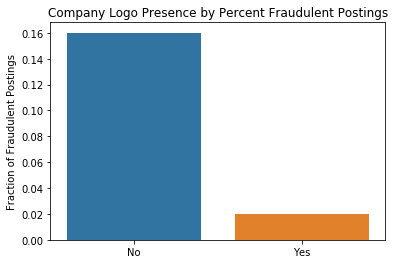

In [40]:
bar_plt('has_company_logo', 'Company Logo Presence', boolean = True)

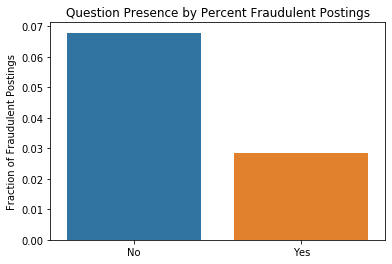

In [41]:
bar_plt('has_questions', 'Question Presence', boolean = True)

Visualize Common Words in Fake vs Real Postings using Scattertext
Tokenize and remove stop words.
Don't lemmatize for exploratory analysis, want words to be human readable

In [43]:
nlp = spacy.load('en')

C:\Users\Light\anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\Light\anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\Light\anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\Light\anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\Light\anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
C:\Users\Light\anaconda3\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **

In [44]:
df['fraudulent_words'] = np.where(df.fraudulent == 1, 'fake', 'real')

In [45]:
# combine text fields into single string 
for c in ['title', 'company_profile', 'description', 'requirements', 'benefits']:
    df[c] = np.where(df[c] == 'missing', '', df[c])
    
df['text'] = (df.title + ' ' + df.company_profile + ' ' + df.description + ' ' + df.requirements + ' ' + df.benefits + ' ' +
              df.industry + ' ' + df.function)
# don't include location (country, state, city) here because will be excluded in lemmatization (proper noun)
# use as metadata

In [46]:
def scattertext_visualize(col):
    
    # spacy nlp cleaning
    df['parse'] = df[col].apply(st.whitespace_nlp_with_sentences)
    
    # corpus artifact
    # remove stop words
    corpus = st.CorpusFromParsedDocuments(
        df, category_col='fraudulent_words', parsed_col='parse'
    ).build().get_unigram_corpus().compact(st.AssociationCompactor(2000)).remove_terms(sw, ignore_absences=True)

    # create html figure
    html = st.produce_scattertext_explorer(
        corpus,
        category='fake', category_name='Fraudulent', not_category_name='Real',
        minimum_term_frequency=0, pmi_threshold_coefficient=0,
        width_in_pixels=1000,
        transform=st.Scalers.dense_rank,
        metadata=corpus.get_df()['title']
    )
    
    # save html
    open('./scattertext_' + col + '.html', 'w').write(html)

In [47]:
# visualize each text field separately and together (text)
nlp_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits', 'text']
for c in nlp_columns:
    scattertext_visualize(c)

Topic Modeling